# Land Surface Temperature and Redlining Grades

Final project
UW Geospatial Data Analysis  
CEE467/CEWA567  
Hoseok Sa

## Part 0: Prepare data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches  # For manual legend
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import xyzservices.providers as xyz
import os
import contextily as ctx
import seaborn as sns
import requests
import zipfile
import shutil
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterstats
import rioxarray as rxr
from matplotlib_scalebar.scalebar import ScaleBar
from pathlib import Path

## Load the data

In [2]:
# Portland Boundaries
portland_fn = './data/Portland_Boundaries.shp'
portland_gdf = gpd.read_file(portland_fn)

# Portland HOLC-grades
portland_holc_fn = './data/Portland_HOLC.shp'
portland_holc_gdf = gpd.read_file(portland_holc_fn)

# Portland Building footprints
portland_bf_holc_fn = './data/Portland_BF_HOLC.shp'
portland_bf_holc_gdf = gpd.read_file(portland_bf_holc_fn)

# Portland temperature 2021
portland_temp_2021_fn = "./data/Landsat_LST_Portland_2021_CloudFiltered_GeoTIFF.tif"
portland_temp_2021_da = rxr.open_rasterio(portland_temp_2021_fn, masked=True).squeeze()

# Portland temperature 2013
portland_temp_2013_fn = "./data/Landsat_LST_Portland_2013_CloudFiltered_GeoTIFF.tif"
portland_temp_2013_da = rxr.open_rasterio(portland_temp_2013_fn, masked=True).squeeze()

# Portland Tree canopy 2021
por_tree_canopy_2021_fn = "./data/TreeCanopy_2021_Portland.tif"
por_tree_canopy_2021_da = rxr.open_rasterio(por_tree_canopy_2021_fn, masked=True).squeeze()

# Portland Impervious surfaces 2021
por_imperv_2021_fn = "./data/Impervious_2021_Portland.tif"
por_imperv_2021_da = rxr.open_rasterio(por_imperv_2021_fn, masked=True).squeeze()

# Portland Tree canopy 2013
por_tree_canopy_2013_fn = "./data/TreeCanopy_2013_Portland.tif"
por_tree_canopy_2013_da = rxr.open_rasterio(por_tree_canopy_2013_fn, masked=True).squeeze()

# Portland Impervious surfaces 2013
por_imperv_2013_fn = "./data/Impervious_2013_Portland.tif"
por_imperv_2013_da = rxr.open_rasterio(por_imperv_2013_fn, masked=True).squeeze()


In [3]:
portland_bf_holc_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Part 1. Data processing (Reprojection)

## Reprojection

In [4]:
# Portland
portland_holc_gdf = portland_holc_gdf.to_crs(portland_gdf.crs)
portland_temp_2021_da = portland_temp_2021_da.rio.reproject(portland_gdf.crs)
portland_temp_2013_da = portland_temp_2013_da.rio.reproject(portland_gdf.crs)
por_tree_canopy_2021_da = por_tree_canopy_2021_da.rio.reproject(portland_gdf.crs)
por_imperv_2021_da  = por_imperv_2021_da.rio.reproject(portland_gdf.crs)
por_tree_canopy_2013_da = por_tree_canopy_2013_da.rio.reproject(portland_gdf.crs)
por_imperv_2013_da  = por_imperv_2013_da.rio.reproject(portland_gdf.crs)

## Clip

## Portland

In [5]:
portland_temp_2021_holc = portland_temp_2021_da.rio.clip(portland_holc_gdf.geometry)
portland_temp_2013_holc = portland_temp_2013_da.rio.clip(portland_holc_gdf.geometry)
portland_tree_2021_holc = por_tree_canopy_2021_da.rio.clip(portland_holc_gdf.geometry)
portland_imperv_2021_holc = por_imperv_2021_da.rio.clip(portland_holc_gdf.geometry)
portland_tree_2013_holc = por_tree_canopy_2013_da.rio.clip(portland_holc_gdf.geometry)
portland_imperv_2013_holc = por_imperv_2013_da.rio.clip(portland_holc_gdf.geometry)

## Calculating Building Density

## Portland

In [6]:
portland_bf_holc_gdf_extent = portland_bf_holc_gdf.total_bounds
portland_bf_holc_gdf_center_x = (portland_bf_holc_gdf_extent[0] + portland_bf_holc_gdf_extent[2])/2
portland_bf_holc_gdf_center_y = (portland_bf_holc_gdf_extent[3] + portland_bf_holc_gdf_extent[1])/2
aea_proj_str = f'+proj=aea +lat_1={portland_bf_holc_gdf_extent[1]:.2f} +lat_2={portland_bf_holc_gdf_extent[3]:.2f} +lat_0={portland_bf_holc_gdf_center_y:.2f} +lon_0={portland_bf_holc_gdf_center_x:.2f}'

In [7]:
aea_proj_str

'+proj=aea +lat_1=45.42 +lat_2=45.60 +lat_0=45.51 +lon_0=-122.66'

In [8]:
portland_holc_gdf_aea = portland_holc_gdf.to_crs(aea_proj_str) # Reproject to AEA for area calculation
portland_bf_holc_gdf_aea = portland_bf_holc_gdf.to_crs(aea_proj_str) # Reproject to AEA for area calculation

In [9]:
# Calculating area for each HOLC graded area
portland_holc_gdf_aea["holc_area"] = portland_holc_gdf_aea.geometry.area
portland_holc_gdf_aea

,area_id,city_id,grade,fill,label,name,category_i,sheets,area,bounds,label_coor,residentia,commercial,industrial,Shape_Leng,Shape_Area,geometry,holc_area
0,6055.0,128.0,C,#ffff00,None,None,3.0,0.0,0.001039,"[[45.46146,-122.62565],[45.5628,-122.56823]]","[45.469,-122.609]",-1,0,0,0.298889,0.001039,"MULTIPOLYGON Z (((3450.025 -4196.867 0, 3445.8...",9.024357e+06
1,6058.0,128.0,B,#7cb5bd,None,None,2.0,0.0,0.000423,"[[45.46196,-122.72521],[45.50698,-122.67396]]","[45.479,-122.705]",-1,0,0,0.298087,0.000423,"MULTIPOLYGON Z (((-2159.127 -4558.652 0, -2032...",3.679206e+06
2,6108.0,128.0,A,#76a865,A1,Gainsborough,1.0,1.0,0.000010,"[[45.5665,-122.67813],[45.56962,-122.67478]]","[45.568,-122.676]",-1,0,0,0.012841,0.000010,"POLYGON Z ((-1153.81 6307.438 0, -1153.813 628...",8.927069e+04
3,6064.0,128.0,A,#76a865,A10,South Portland Heights,1.0,1.0,0.000084,"[[45.50091,-122.7128],[45.51038,-122.695]]","[45.507,-122.703]",-1,0,0,0.062677,0.000084,"POLYGON Z ((-3271.884 21.97 0, -2735.121 -173....",7.286372e+05
4,6135.0,128.0,A,#76a865,A11,Council Crest,1.0,1.0,0.000075,"[[45.49061,-122.71056],[45.50029,-122.69549]]","[45.495,-122.701]",-1,0,0,0.057179,0.000075,"POLYGON Z ((-2841.959 -1410.857 0, -2845.895 -...",6.529334e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,6080.0,128.0,D,#d9838d,D5,Richmond,4.0,1.0,0.000213,"[[45.49677,-122.65178],[45.51167,-122.62265]]","[45.503,-122.626]",-1,0,0,0.084350,0.000213,"POLYGON Z ((2902.194 171.83 0, 2915.015 -513.9...",1.849554e+06
88,6078.0,128.0,D,#d9838d,D6,Northwest Side,4.0,1.0,0.000116,"[[45.523,-122.70799],[45.54102,-122.69032]]","[45.536,-122.697]",-1,0,0,0.067477,0.000116,"POLYGON Z ((-2535.969 1459.807 0, -2553.598 22...",1.004816e+06
89,6068.0,128.0,D,#d9838d,D7,Central West Side,4.0,1.0,0.000043,"[[45.51298,-122.69296],[45.5219,-122.68393]]","[45.518,-122.689]",-1,0,0,0.030045,0.000043,"POLYGON Z ((-1869.694 990.553 0, -2111.343 331...",3.761370e+05
90,6069.0,128.0,D,#d9838d,D8,Southwest River District,4.0,1.0,0.000155,"[[45.4895,-122.68435],[45.51773,-122.67326]]","[45.501,-122.678]",-1,0,0,0.075890,0.000155,"POLYGON Z ((-1244.506 -2278.281 0, -1415.704 -...",1.347484e+06


In [10]:
# Intersect between building footprints and HOLC grade boundaries
intersection = gpd.overlay(portland_bf_holc_gdf_aea, portland_holc_gdf_aea, how='intersection')
intersection["building_area"] = intersection.geometry.area

In [11]:
# Calculating building area for each area id
building_area_holc = intersection.groupby("area_id")["building_area"].sum().reset_index()
building_area_holc

,area_id,building_area
0,6040.0,163625.970845
1,6041.0,117005.141761
2,6042.0,75827.040985
3,6043.0,19036.386428
4,6044.0,52423.790753
...,...,...
87,6131.0,109338.879205
88,6132.0,264121.433759
89,6133.0,162158.626737
90,6134.0,201017.496679


In [12]:
# Merging the aggregated building area to the HOLC grade layer & Calculating building density
holc_merged = portland_holc_gdf_aea.merge(building_area_holc, on="area_id", how="left")
holc_merged["building_area"] = holc_merged["building_area"].fillna(0)
holc_merged["building_density"] = holc_merged["building_area"] / holc_merged["holc_area"]*100
holc_merged.sort_values(by="building_density", ascending=False)

,area_id,city_id,grade,fill,label,name,category_i,sheets,area,bounds,label_coor,residentia,commercial,industrial,Shape_Leng,Shape_Area,geometry,holc_area,building_area,building_density
88,6078.0,128.0,D,#d9838d,D6,Northwest Side,4.0,1.0,0.000116,"[[45.523,-122.70799],[45.54102,-122.69032]]","[45.536,-122.697]",-1,0,0,0.067477,0.000116,"POLYGON Z ((-2535.969 1459.807 0, -2553.598 22...",1.004816e+06,322985.664114,32.143770
73,6077.0,128.0,C,#ffff00,C33,Northern Goldsmith Addition,3.0,1.0,0.000090,"[[45.52313,-122.71871],[45.53832,-122.69246]]","[45.528,-122.695]",-1,0,0,0.078071,0.000090,"POLYGON Z ((-3748.407 2896.372 0, -3360.991 28...",7.837693e+05,238507.183236,30.430790
86,6082.0,128.0,D,#d9838d,D4,Central East Side and Sunnyside,4.0,1.0,0.000286,"[[45.51257,-122.66002],[45.53098,-122.6349]]","[45.523,-122.639]",-1,0,0,0.187937,0.000286,"MULTIPOLYGON Z (((1088.414 771.42 0, 1085.308 ...",2.480319e+06,697115.567074,28.105883
37,6071.0,128.0,B,#7cb5bd,B27,Washington Park,2.0,1.0,0.000015,"[[45.51969,-122.70073],[45.52387,-122.69682]]","[45.522,-122.699]",-1,0,0,0.015371,0.000015,"POLYGON Z ((-3014.851 1521.147 0, -2920.326 15...",1.306048e+05,36414.981564,27.881809
89,6068.0,128.0,D,#d9838d,D7,Central West Side,4.0,1.0,0.000043,"[[45.51298,-122.69296],[45.5219,-122.68393]]","[45.518,-122.689]",-1,0,0,0.030045,0.000043,"POLYGON Z ((-1869.694 990.553 0, -2111.343 331...",3.761370e+05,99034.636401,26.329408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,6061.0,128.0,C,#ffff00,C35,Sam Jackson Park,3.0,1.0,0.000058,"[[45.4942,-122.69731],[45.50362,-122.68911]]","[45.498,-122.693]",-1,0,0,0.033863,0.000058,"POLYGON Z ((-2845.895 -1471.983 0, -2841.959 -...",5.068780e+05,39218.040656,7.737175
16,6075.0,128.0,A,#76a865,A8,The Highlands,1.0,1.0,0.000038,"[[45.5071,-122.72605],[45.51546,-122.71981]]","[45.513,-122.722]",-1,0,0,0.028750,0.000038,"POLYGON Z ((-5046.844 604.419 0, -4915.58 597....",3.270335e+05,23651.443896,7.232117
9,6040.0,128.0,A,#76a865,A16,Dunthorp,1.0,1.0,0.000287,"[[45.42333,-122.67449],[45.43726,-122.65133]]","[45.43,-122.663]",-1,0,0,0.070035,0.000287,"POLYGON Z ((678.395 -8204.402 0, 388.182 -9499...",2.492387e+06,163625.970845,6.565031
8,6042.0,128.0,A,#76a865,A15,Riverview and Abernathy Heights,1.0,1.0,0.000138,"[[45.43606,-122.66237],[45.44953,-122.64683]]","[45.443,-122.657]",-1,0,0,0.051408,0.000139,"POLYGON Z ((678.395 -8204.402 0, 573.544 -8191...",1.204385e+06,75827.040985,6.295912


## Zonal stats

## Portland

In [13]:
# Temperature 2021
temp_2021_por_array = portland_temp_2021_holc.values
temp_2021_por_transform = portland_temp_2021_holc.rio.transform()
temp_2021_por_nodata_value = portland_temp_2021_holc.rio.nodata
temp_2021_por_zonal_stats = rasterstats.zonal_stats(portland_holc_gdf, temp_2021_por_array, affine = temp_2021_por_transform, nodata = temp_2021_por_nodata_value,
                                              stats= ['mean', 'std', 'max', 'min'])

In [14]:
# Temperature 2013
temp_2013_por_array = portland_temp_2013_holc.values
temp_2013_por_transform = portland_temp_2013_holc.rio.transform()
temp_2013_por_nodata_value = portland_temp_2013_holc.rio.nodata
temp_2013_por_zonal_stats = rasterstats.zonal_stats(portland_holc_gdf, temp_2013_por_array, affine = temp_2013_por_transform, nodata = temp_2013_por_nodata_value,
                                              stats= ['mean', 'std', 'max', 'min'])

In [15]:
# Tree cover 2021
tree_2021_por_array = portland_tree_2021_holc.values
tree_2021_por_transform = portland_tree_2021_holc.rio.transform()
tree_2021_por_nodata_value = portland_tree_2021_holc.rio.nodata
tree_2021_por_zonal_stats = rasterstats.zonal_stats(portland_holc_gdf, tree_2021_por_array, affine = tree_2021_por_transform, nodata = tree_2021_por_nodata_value,
                                              stats= ['mean', 'std', 'max', 'min'])

In [16]:
# Tree cover 2013
tree_2013_por_array = portland_tree_2013_holc.values
tree_2013_por_transform = portland_tree_2013_holc.rio.transform()
tree_2013_por_nodata_value = portland_tree_2013_holc.rio.nodata
tree_2013_por_zonal_stats = rasterstats.zonal_stats(portland_holc_gdf, tree_2013_por_array, affine = tree_2013_por_transform, nodata = tree_2013_por_nodata_value,
                                              stats= ['mean', 'std', 'max', 'min'])

In [17]:
# Impervious surfaces 2021
imperv_2021_por_array = portland_imperv_2021_holc.values
imperv_2021_por_transform = portland_imperv_2021_holc.rio.transform()
imperv_2021_por_nodata_value = portland_imperv_2021_holc.rio.nodata
imperv_2021_por_zonal_stats = rasterstats.zonal_stats(portland_holc_gdf, imperv_2021_por_array, affine = imperv_2021_por_transform, nodata = imperv_2021_por_nodata_value,
                                              stats= ['mean', 'std', 'max', 'min'])

In [18]:
# Impervious surfaces 2013
imperv_2013_por_array = portland_imperv_2013_holc.values
imperv_2013_por_transform = portland_imperv_2013_holc.rio.transform()
imperv_2013_por_nodata_value = portland_imperv_2013_holc.rio.nodata
imperv_2013_por_zonal_stats = rasterstats.zonal_stats(portland_holc_gdf, imperv_2013_por_array, affine = imperv_2013_por_transform, nodata = imperv_2013_por_nodata_value,
                                              stats= ['mean', 'std', 'max', 'min'])

In [19]:
# Incorporating variables to HOLC grade gdf
portland_holc_gdf['temp2021_mean'] = [stat["mean"] for stat in temp_2021_por_zonal_stats]
portland_holc_gdf['temp2021_std'] = [stat["std"] for stat in temp_2021_por_zonal_stats]
portland_holc_gdf['temp2013_mean'] = [stat["mean"] for stat in temp_2013_por_zonal_stats]
portland_holc_gdf['temp2013_std'] = [stat["std"] for stat in temp_2013_por_zonal_stats]
portland_holc_gdf['tree2021_mean'] = [stat["mean"] for stat in tree_2021_por_zonal_stats]
portland_holc_gdf['tree2021_std'] = [stat["std"] for stat in tree_2021_por_zonal_stats]
portland_holc_gdf['imperv2021_mean'] = [stat["mean"] for stat in imperv_2021_por_zonal_stats]
portland_holc_gdf['imperv2021_std'] = [stat["std"] for stat in imperv_2021_por_zonal_stats]
portland_holc_gdf['tree2013_mean'] = [stat["mean"] for stat in tree_2013_por_zonal_stats]
portland_holc_gdf['tree2013_std'] = [stat["std"] for stat in tree_2013_por_zonal_stats]
portland_holc_gdf['imperv2013_mean'] = [stat["mean"] for stat in imperv_2013_por_zonal_stats]
portland_holc_gdf['imperv2013_std'] = [stat["std"] for stat in imperv_2013_por_zonal_stats]

portland_holc_gdf

,area_id,city_id,grade,fill,label,name,category_i,sheets,area,bounds,...,temp2013_mean,temp2013_std,tree2021_mean,tree2021_std,imperv2021_mean,imperv2021_std,tree2013_mean,tree2013_std,imperv2013_mean,imperv2013_std
0,6055.0,128.0,C,#ffff00,None,None,3.0,0.0,0.001039,"[[45.46146,-122.62565],[45.5628,-122.56823]]",...,39.777442,1.501790,21.522312,16.434639,52.316786,15.689843,22.242543,11.418458,52.205264,15.716935
1,6058.0,128.0,B,#7cb5bd,None,None,2.0,0.0,0.000423,"[[45.46196,-122.72521],[45.50698,-122.67396]]",...,35.335430,2.242317,39.775754,18.524725,42.911414,19.687106,41.379055,17.485721,43.060761,19.624969
2,6108.0,128.0,A,#76a865,A1,Gainsborough,1.0,1.0,0.000010,"[[45.5665,-122.67813],[45.56962,-122.67478]]",...,NaN,NaN,28.125000,13.703140,53.854167,9.989556,29.125000,9.483813,54.166667,9.719682
3,6064.0,128.0,A,#76a865,A10,South Portland Heights,1.0,1.0,0.000084,"[[45.50091,-122.7128],[45.51038,-122.695]]",...,30.541800,1.605200,55.276353,14.140543,26.660969,14.413971,57.504274,12.596945,26.903134,14.546390
4,6135.0,128.0,A,#76a865,A11,Council Crest,1.0,1.0,0.000075,"[[45.49061,-122.71056],[45.50029,-122.69549]]",...,29.067684,1.932879,55.776358,17.241041,22.394904,17.470178,58.210863,15.505135,22.656051,17.721739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,6080.0,128.0,D,#d9838d,D5,Richmond,4.0,1.0,0.000213,"[[45.49677,-122.65178],[45.51167,-122.62265]]",...,40.101812,1.323815,28.297550,11.866976,62.373396,11.711154,28.814469,10.490953,63.172695,10.397942
88,6078.0,128.0,D,#d9838d,D6,Northwest Side,4.0,1.0,0.000116,"[[45.523,-122.70799],[45.54102,-122.69032]]",...,42.668365,2.660044,8.405680,13.324234,82.535497,10.500520,9.466531,13.885996,82.685598,10.215355
89,6068.0,128.0,D,#d9838d,D7,Central West Side,4.0,1.0,0.000043,"[[45.51298,-122.69296],[45.5219,-122.68393]]",...,39.388965,2.178974,9.966667,14.142882,81.955556,9.565460,10.938889,14.049185,82.166667,9.778378
90,6069.0,128.0,D,#d9838d,D8,Southwest River District,4.0,1.0,0.000155,"[[45.4895,-122.68435],[45.51773,-122.67326]]",...,39.173629,1.559605,20.413793,18.923736,68.312402,16.818116,24.253918,17.562377,69.697017,15.842361


## Part 2. Data Analysis

## Descriptive Statistics

## Portland

In [20]:
portland_files = {"portland_temp_2021_holc": portland_temp_2021_holc, 
                  "portland_temp_2013_holc": portland_temp_2013_holc, 
                  "portland_tree_2021_holc": portland_tree_2021_holc, 
                  "portland_imperv_2021_holc": portland_imperv_2021_holc, 
                  "portland_tree_2013_holc": portland_tree_2013_holc, 
                  "portland_imperv_2013_holc": portland_imperv_2013_holc}

In [21]:
# To make a single table with descriptive statistics for focal variables
all_summaries = []

for label, raster_data in portland_files.items(): 

    data = raster_data.values
    
    valid_pixels = data.flatten()
    valid_pixels = valid_pixels[~np.isnan(valid_pixels)]

    if "tree" in label.lower() or "imperv" in label.lower():
        valid_pixels = valid_pixels[valid_pixels <= 100] 
    
    df = pd.DataFrame(valid_pixels, columns = ["Pixel Value"])
    summary = df.describe().T
    summary["Raster"] = label
    
    all_summaries.append(summary)

portland_summary_df = pd.concat(all_summaries, ignore_index=True)
portland_summary_df

,count,mean,std,min,25%,50%,75%,max,Raster
0,735.0,38.167960,3.860859,24.414239,36.827633,39.00064,40.713922,47.006497,portland_temp_2021_holc
1,735.0,38.299584,3.606689,24.977073,37.451707,39.20743,40.442474,46.340838,portland_temp_2013_holc
2,50578.0,27.843311,17.745516,0.000000,20.000000,27.00000,36.000000,84.000000,portland_tree_2021_holc
3,50602.0,54.689972,20.068123,0.000000,47.000000,59.00000,66.000000,100.000000,portland_imperv_2021_holc
4,50587.0,28.999763,17.070896,0.000000,21.000000,27.00000,36.000000,84.000000,portland_tree_2013_holc
5,50602.0,54.918106,19.903509,0.000000,48.000000,59.00000,66.000000,99.000000,portland_imperv_2013_holc


## Part 3. Data Visualization

## Portland

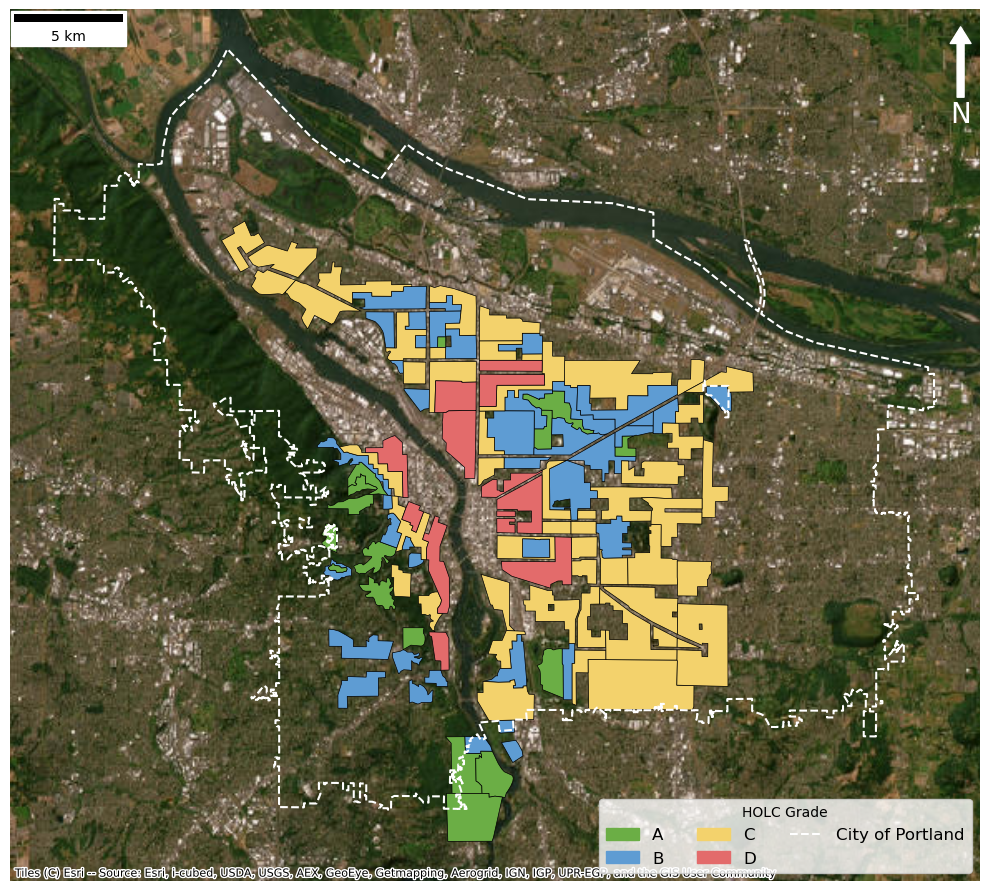

In [22]:
# HOLC-grades with boundaries
holc_colors = {"A": "#6BAE45",  # Green
               "B": "#5E9CD3",  # Blue
               "C": "#F3D26C",  # Yellow
               "D": "#E36B6B"}  # Red

x, y, arrow_length = 0.98, 0.98, 0.1

f, ax = plt.subplots(figsize= (10, 10))

portland_holc_gdf.plot(ax=ax, color=portland_holc_gdf['grade'].map(holc_colors), 
                       edgecolor="black", linewidth=0.5, zorder=2)
portland_gdf.plot(ax=ax, facecolor='none', edgecolor='white', linestyle = 'dashed', linewidth=1.5, zorder=3)
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=portland_holc_gdf.crs, zorder=1)

ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax.transAxes) # For north arrow

holc_handles = [mpatches.Patch(color=holc_colors[grade], label=f"{grade}") 
                for grade in sorted(holc_colors.keys())] # For legend

boundary_handle = mlines.Line2D([], [], color='white', linestyle='dashed', 
                                linewidth=1.5, label="City of Portland")

legend_handles = holc_handles + [boundary_handle]

ax.legend(handles=legend_handles, loc='lower right', title="HOLC Grade", fontsize=12, ncol=3)

scalebar = ScaleBar(1.0, location='upper left')
ax.add_artist(scalebar)

ax.axis('off')
    
f.tight_layout()  

# plt.savefig("./results/portland_holc_map.pdf", format="pdf", dpi=300, bbox_inches="tight")
# plt.savefig("./results/portland_holc_map.png", format="png", dpi=300, bbox_inches="tight")

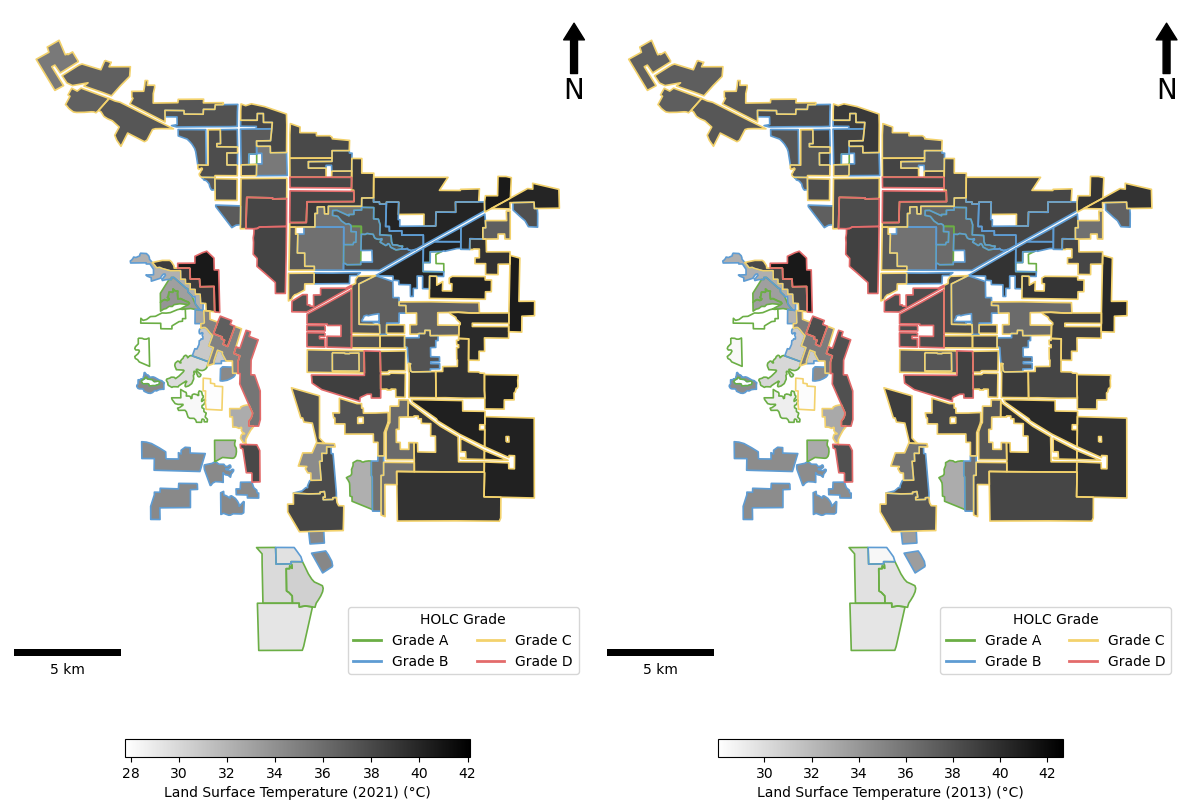

In [23]:
# LST with HOLC-grades
holc_colors = {"A": "#6BAE45",  # Green
               "B": "#5E9CD3",  # Blue
               "C": "#F3D26C",  # Yellow
               "D": "#E36B6B"}  # Red

x, y, arrow_length = 0.98, 0.98, 0.1

f, ax = plt.subplots(1, 2, figsize= (12, 12))

portland_holc_gdf.plot(ax=ax[0], column='temp2021_mean', cmap='gray_r', alpha=0.9, legend=True,
                      legend_kwds ={'label': "Land Surface Temperature (2021) (°C)", 'orientation': "horizontal", 'pad': 0.05, 'shrink': 0.6}, zorder=1)
portland_holc_gdf.plot(ax=ax[0], edgecolor=portland_holc_gdf['grade'].map(holc_colors), facecolor='none', linewidth=1.2, zorder=2)

ax[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax[0].transAxes) # For north arrow

holc_handles = [
    mlines.Line2D([], [], color=color, linewidth=2, label=f"Grade {grade}")
    for grade, color in holc_colors.items()
] # For legend

ax[0].legend(handles=holc_handles, loc='lower right', title='HOLC Grade', ncol=2)

scalebar = ScaleBar(1.0, location='lower left')
ax[0].add_artist(scalebar)

ax[0].axis('off')
ax[0].set_title(None)

portland_holc_gdf.plot(ax=ax[1], column='temp2013_mean', cmap='gray_r', alpha=0.9, legend=True,
                      legend_kwds ={'label': "Land Surface Temperature (2013) (°C)", 'orientation': "horizontal", 'pad': 0.05, 'shrink': 0.6}, zorder=1)
portland_holc_gdf.plot(ax=ax[1], edgecolor=portland_holc_gdf['grade'].map(holc_colors), facecolor='none', linewidth=1.2, zorder=2)

ax[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax[1].transAxes) # For north arrow

holc_handles = [
    mlines.Line2D([], [], color=color, linewidth=2, label=f"Grade {grade}")
    for grade, color in holc_colors.items()
] # For legend

ax[1].legend(handles=holc_handles, loc='lower right', title='HOLC Grade', ncol=2)

scalebar = ScaleBar(1.0, location='lower left')
ax[1].add_artist(scalebar)

ax[1].axis('off')
ax[1].set_title(None)

f.tight_layout()  

# plt.savefig("./results/portland_holc_temp2021.pdf", format="pdf", dpi=300, bbox_inches="tight")
# plt.savefig("./results/portland_holc_temp2021.png", format="png", dpi=300, bbox_inches="tight")

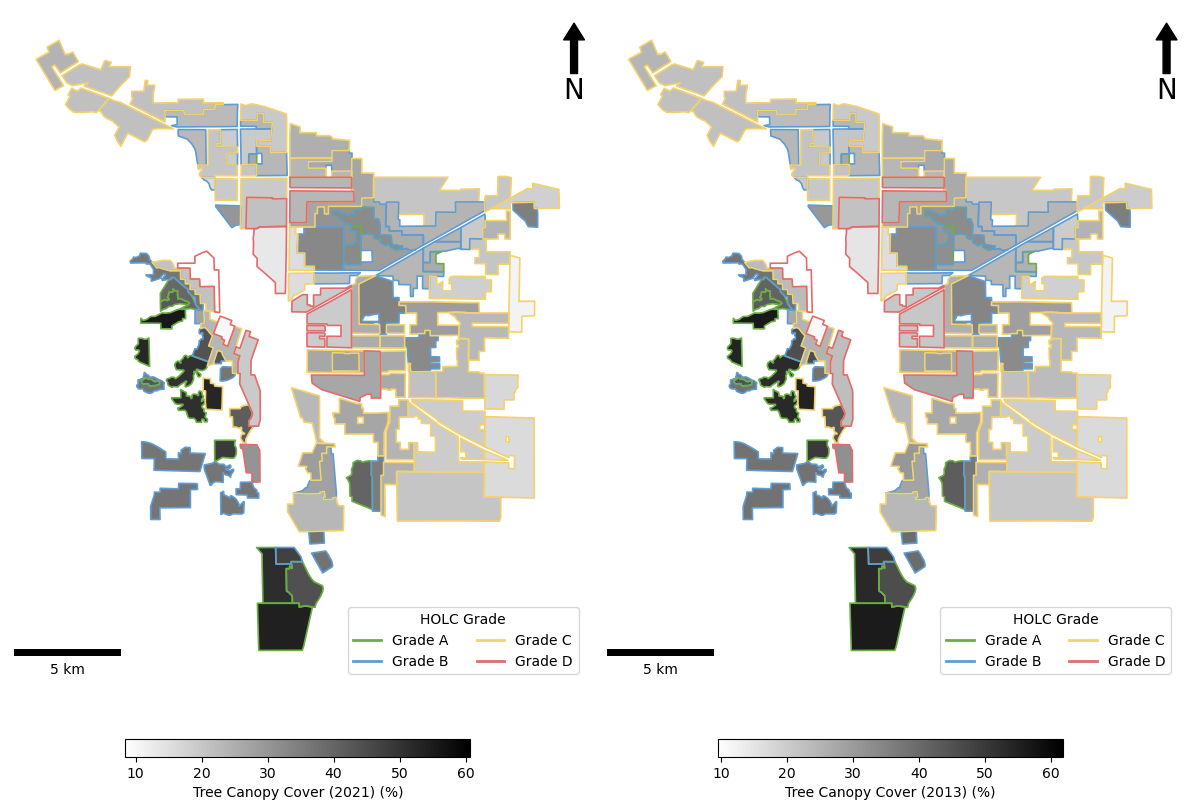

In [24]:
# Tree Canopy with HOLC-grades
holc_colors = {"A": "#6BAE45",  # Green
               "B": "#5E9CD3",  # Blue
               "C": "#F3D26C",  # Yellow
               "D": "#E36B6B"}  # Red

x, y, arrow_length = 0.98, 0.98, 0.1

f, ax = plt.subplots(1, 2, figsize= (12, 12))

portland_holc_gdf.plot(ax=ax[0], column='tree2021_mean', cmap='gray_r', alpha=0.9, legend=True,
                      legend_kwds ={'label': "Tree Canopy Cover (2021) (%)", 'orientation': "horizontal", 'pad': 0.05, 'shrink': 0.6}, zorder=1)
portland_holc_gdf.plot(ax=ax[0], edgecolor=portland_holc_gdf['grade'].map(holc_colors), facecolor='none', linewidth=1.2, zorder=2)

ax[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax[0].transAxes) # For north arrow

holc_handles = [
    mlines.Line2D([], [], color=color, linewidth=2, label=f"Grade {grade}")
    for grade, color in holc_colors.items()
] # For legend

ax[0].legend(handles=holc_handles, loc='lower right', title='HOLC Grade', ncol=2)

scalebar = ScaleBar(1.0, location='lower left')
ax[0].add_artist(scalebar)

ax[0].axis('off')
ax[0].set_title(None)

portland_holc_gdf.plot(ax=ax[1], column='tree2013_mean', cmap='gray_r', alpha=0.9, legend=True,
                      legend_kwds ={'label': "Tree Canopy Cover (2013) (%)", 'orientation': "horizontal", 'pad': 0.05, 'shrink': 0.6}, zorder=1)
portland_holc_gdf.plot(ax=ax[1], edgecolor=portland_holc_gdf['grade'].map(holc_colors), facecolor='none', linewidth=1.2, zorder=2)

ax[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax[1].transAxes) # For north arrow

holc_handles = [
    mlines.Line2D([], [], color=color, linewidth=2, label=f"Grade {grade}")
    for grade, color in holc_colors.items()
] # For legend

ax[1].legend(handles=holc_handles, loc='lower right', title='HOLC Grade', ncol=2)

scalebar = ScaleBar(1.0, location='lower left')
ax[1].add_artist(scalebar)

ax[1].axis('off')
ax[1].set_title(None)
    
f.tight_layout()  

# plt.savefig("./results/portland_holc_treecanopy.pdf", format="pdf", dpi=300, bbox_inches="tight")
# plt.savefig("./results/portland_holc_treecanopy.png", format="png", dpi=300, bbox_inches="tight")

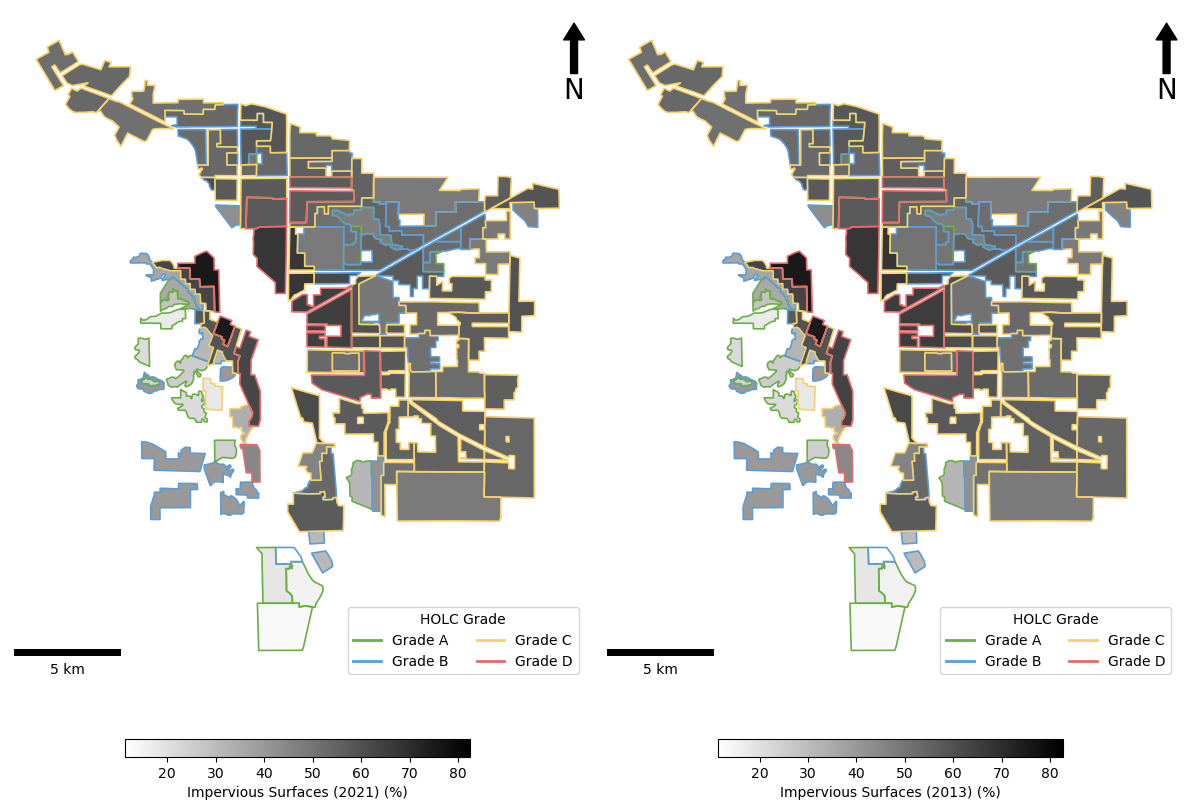

In [25]:
# Impervious surfaces with HOLC-grades
holc_colors = {"A": "#6BAE45",  # Green
               "B": "#5E9CD3",  # Blue
               "C": "#F3D26C",  # Yellow
               "D": "#E36B6B"}  # Red

x, y, arrow_length = 0.98, 0.98, 0.1

f, ax = plt.subplots(1, 2, figsize= (12, 12))

portland_holc_gdf.plot(ax=ax[0], column='imperv2021_mean', cmap='gray_r', alpha=0.9, legend=True,
                      legend_kwds ={'label': "Impervious Surfaces (2021) (%)", 'orientation': "horizontal", 'pad': 0.05, 'shrink': 0.6}, zorder=1)
portland_holc_gdf.plot(ax=ax[0], edgecolor=portland_holc_gdf['grade'].map(holc_colors), facecolor='none', linewidth=1.2, zorder=2)

ax[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax[0].transAxes) # For north arrow

holc_handles = [
    mlines.Line2D([], [], color=color, linewidth=2, label=f"Grade {grade}")
    for grade, color in holc_colors.items()
] # For legend

ax[0].legend(handles=holc_handles, loc='lower right', title='HOLC Grade', ncol=2)

scalebar = ScaleBar(1.0, location='lower left')
ax[0].add_artist(scalebar)

ax[0].axis('off')
ax[0].set_title(None)

portland_holc_gdf.plot(ax=ax[1], column='imperv2013_mean', cmap='gray_r', alpha=0.9, legend=True,
                      legend_kwds ={'label': "Impervious Surfaces (2013) (%)", 'orientation': "horizontal", 'pad': 0.05, 'shrink': 0.6}, zorder=1)
portland_holc_gdf.plot(ax=ax[1], edgecolor=portland_holc_gdf['grade'].map(holc_colors), facecolor='none', linewidth=1.2, zorder=2)

ax[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax[1].transAxes) # For north arrow

holc_handles = [
    mlines.Line2D([], [], color=color, linewidth=2, label=f"Grade {grade}")
    for grade, color in holc_colors.items()
] # For legend

ax[1].legend(handles=holc_handles, loc='lower right', title='HOLC Grade', ncol=2)

scalebar = ScaleBar(1.0, location='lower left')
ax[1].add_artist(scalebar)

ax[1].axis('off')
ax[1].set_title(None)
    
f.tight_layout()  

# plt.savefig("./results/portland_holc_impervsurface.pdf", format="pdf", dpi=300, bbox_inches="tight")
# plt.savefig("./results/portland_holc_impervsurface.png", format="png", dpi=300, bbox_inches="tight")

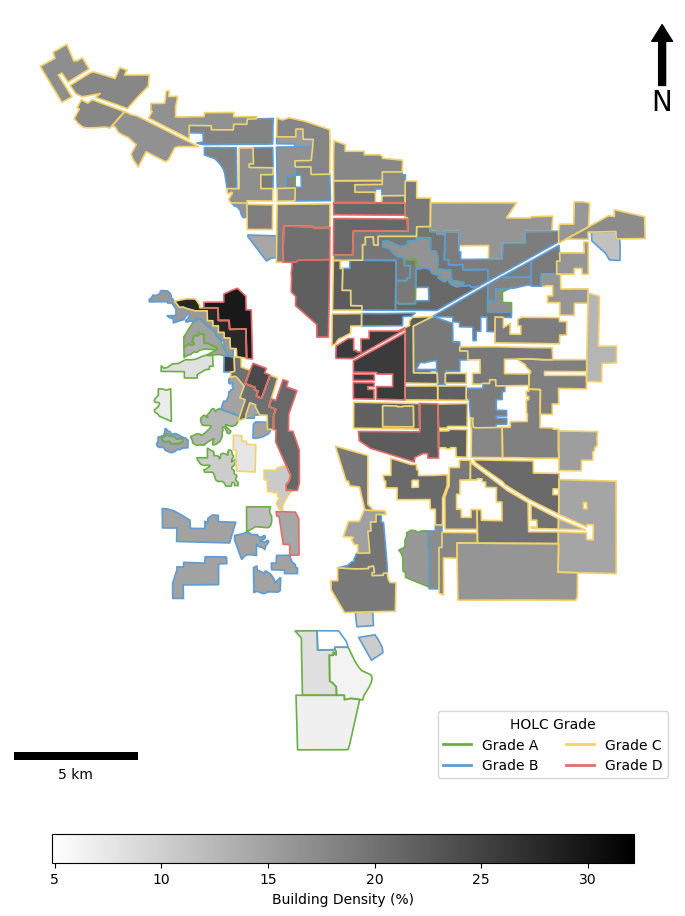

In [26]:
# Building density with HOLC-grades
holc_colors = {"A": "#6BAE45",  # Green
               "B": "#5E9CD3",  # Blue
               "C": "#F3D26C",  # Yellow
               "D": "#E36B6B"}  # Red

x, y, arrow_length = 0.98, 0.98, 0.1

holc_merged = holc_merged.to_crs(portland_holc_gdf.crs)

f, ax = plt.subplots(figsize= (10, 10))

holc_merged.plot(ax=ax, column='building_density', cmap='gray_r', alpha=0.9, legend=True,
                 legend_kwds ={'label': "Building Density (%)", 'orientation': "horizontal", 'pad': 0.05, 'shrink': 0.6}, zorder=1)
portland_holc_gdf.plot(ax=ax, edgecolor=portland_holc_gdf['grade'].map(holc_colors), facecolor='none', linewidth=1.2, zorder=2)

ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax.transAxes) # For north arrow

holc_handles = [
    mlines.Line2D([], [], color=color, linewidth=2, label=f"Grade {grade}")
    for grade, color in holc_colors.items()
] # For legend

ax.legend(handles=holc_handles, loc='lower right', title='HOLC Grade', ncol=2)

scalebar = ScaleBar(1.0, location='lower left')
ax.add_artist(scalebar)

ax.axis('off')
ax.set_title(None)
    
f.tight_layout()  

# plt.savefig("./results/portland_holc_buildingdensity.pdf", format="pdf", dpi=300, bbox_inches="tight")
# plt.savefig("./results/portland_holc_buildingdensity.png", format="png", dpi=300, bbox_inches="tight")

## Part 4. Data export

In [27]:
# HoLC grade GeoDataFrame with several variables
portland_holc_gdf.drop(columns="geometry").to_csv("./results/portland_holc.csv", index=False)

In [28]:
# Building density
holc_merged.to_csv("./results/portland_holc_bf.csv")

In [29]:
# Descriptive statistics
portland_summary_df.to_csv("./results/portland_summary.csv")